|   density_altitude |   kcas |   ktas |    eta |   thrust |   drag |   roc |   aoc |   ftnm |   pre |      pav |    pxs |     rpm |   pbhp |   gph |   fuel_flow_per_knot |   mpg |
|--------------------|--------|--------|--------|----------|--------|-------|-------|--------|-------|----------|--------|---------|--------|-------|----------------------|-------|
|                  0 |  115.7 |  115.7 | 0.7608 |    327.3 |  327.1 |     1 |     0 |      1 | 63873 | 63918.86 |  46.06 | 2400.00 |  64.95 | 11.70 |                 1.68 |  9.89 |
|               1000 |  115.1 |  116.8 | 0.7624 |    324.9 |  324.8 |     1 |     0 |      0 | 64027 | 64048.91 |  21.86 | 2400.00 |  64.98 | 11.71 |                 1.65 |  9.98 |
|               2000 |  114.4 |  117.8 | 0.7640 |    322.8 |  322.1 |     3 |     0 |      2 | 64057 | 64188.85 | 132.15 | 2400.00 |  64.87 | 11.69 |                 1.62 | 10.08 |
|               3000 |  113.8 |  119.0 | 0.7657 |    320.4 |  319.9 |     2 |     0 |      1 | 

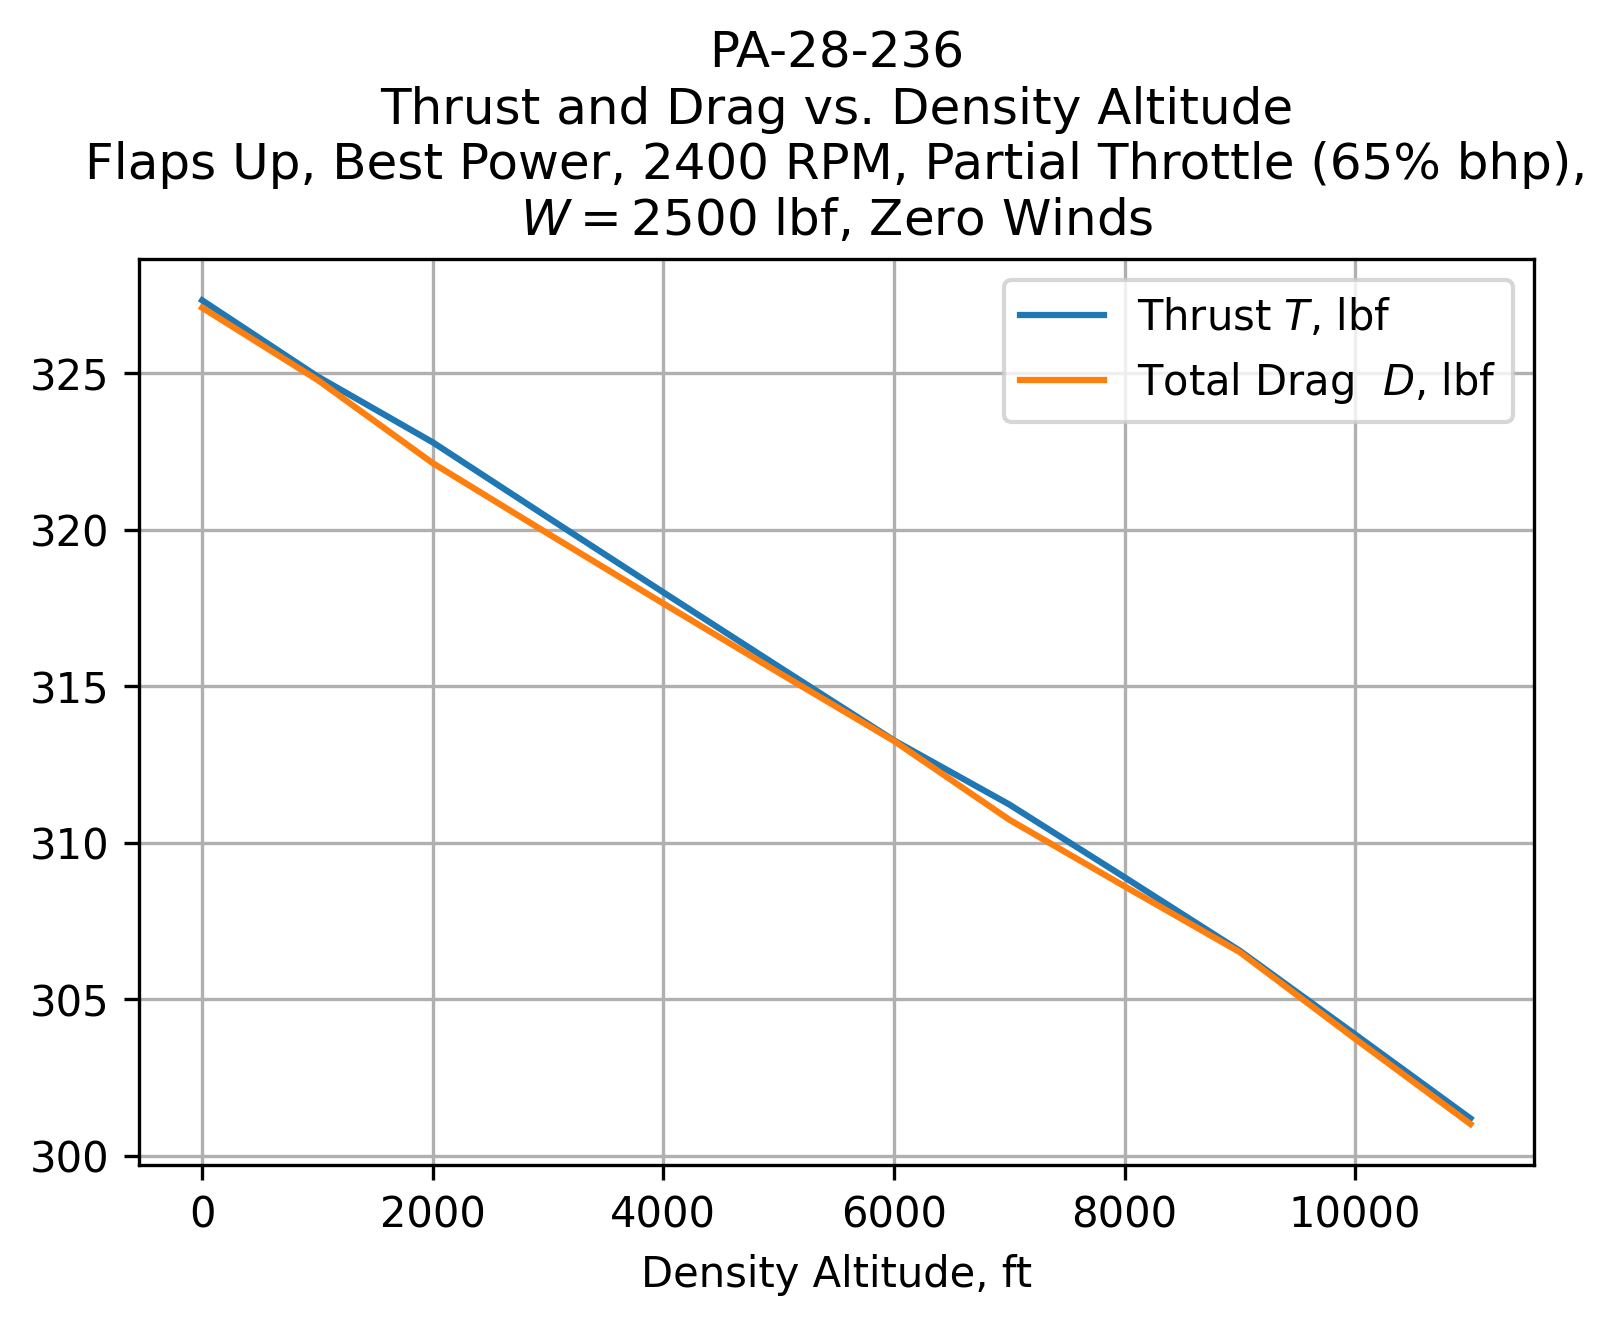

In [10]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

from the_bootstrap_approach.conditions import PartialThrottleConditions
from the_bootstrap_approach.equations import *
from the_bootstrap_approach.mixture import Mixture
from the_bootstrap_approach.performance import bootstrap_cruise_performance_table

from n51sw_dataplate import N51SW


def thrust_drag_vs_altitude(mixture, gross_aircraft_weight):
    thrust = []
    drag = []

    by_altitude_table = []

    x = np.arange(0, 12000, 1000)

    for pressure_altitude in x:
        oat_f = british_standard_temperature(pressure_altitude)

        table = bootstrap_cruise_performance_table(
            N51SW,
            PartialThrottleConditions(
                N51SW,
                gross_aircraft_weight,
                pressure_altitude,
                oat_f,
                mixture,
                2200,
                N51SW.rated_full_throttle_engine_power * 0.65,
            ),
            60,
            180,
            0.1,
            expanded=True,
        )

        # V_y, best rate of climb.
        roc = table[:, 5]
        index_of_highest_roc = roc.argmax()

        # V_M, maximum level flight speed.
        roc_after_peak = roc[index_of_highest_roc:]
        index_max_level_flight_speed = (
            np.where(roc_after_peak > 0, roc_after_peak, np.inf).argmin()
            + index_of_highest_roc
        )

        by_altitude_table.append(
            np.insert(table[index_max_level_flight_speed], 0, pressure_altitude)
        )

        thrust.append(table[index_max_level_flight_speed][3])
        drag.append(table[index_max_level_flight_speed][4])

    headers = (
        "density_altitude",
        "kcas",
        "ktas",
        "eta",
        "thrust",
        "drag",
        "roc",
        "aoc",
        "ftnm",
        "pre",
        "pav",
        "pxs",
        "rpm",
        "pbhp",
        "gph",
        "fuel_flow_per_knot",
        "mpg",
    )
    tablefmt = "github"
    floatfmt = (
        ".0f",
        ".1f",
        ".1f",
        ".4f",
        ".1f",
        ".1f",
        ".0f",
        ".0f",
        ".0f",
        ".0f",
        ".2f",
        ".2f",
        ".2f",
        ".2f",
        ".2f",
        ".2f",
        ".2f",
    )
    print(
        tabulate(
            by_altitude_table,
            headers=headers,
            tablefmt=tablefmt,
            floatfmt=floatfmt,
        )
    )

    fig, ax = plt.subplots()

    ax.plot(x, thrust, label=r"Thrust $T$, lbf")
    ax.plot(x, drag, label=r"Total Drag  $D$, lbf")

    ax.set(
        xlabel="Density Altitude, ft",
        title=(
            "PA-28-236\n"
            "Thrust and Drag vs. Density Altitude\n"
            f"{N51SW.configuration}, "
            f"{mixture.value}, "
            f"2200 RPM, "
            f"Partial Throttle ({0.65 * 100:.0f}% bhp),\n"
            f"$W = {gross_aircraft_weight}$ lbf, "
            f"Zero Winds"
        ),
    )

    ax.grid(True, which="both")

    plt.legend()

    fig.set(dpi=300)
    plt.show()


thrust_drag_vs_altitude(Mixture.BEST_POWER, 2500)